Logistic regression is a common model for classification problems. It is applicabale to both binary and multiclass classification, however for starters it's necessary to understand the logic behind the use of logistic regression in binary classification problem. 
<br/><br/>
The basis of logistic regression is **sigmoid** function: $\sigma(x)=\frac{1}{1+e^{-x}}$ It's highly applicable in classification problemnts, since it is close to either 0 or 1 across most of its domain:

In [3]:
import numpy as np
import plotly.express as px

sigmoid = lambda x: 1 / (1+np.exp(-x))
X = np.arange(-20,20)
px.line(x=X, y=sigmoid(X), title=r'$\sigma(x)$')

Another important term is **logit**, which is a logarithm of odds. **Odds** is a ratio between probabilities $\frac{p}{1-p}$. Since both odds and logits are monotonically increasing functions, we can apply log-transformation to odds.
<br/><br/>
It is important to explain the intuition behind odds. **Odds** is a quantitive measure of a success. Suppose $p=0,8$ and $q=1-p=0,2$. Therefore the odds of a success will be $\frac{0,8}{0,2}=4$. This can be best interpreted as "we encounter an unfavorable outcome once in every 4+1 events". Therefore, the higher is the $p$, the higher are the odds.
<br/><br/>
As to **logits**, the function approaches $-\infty$ for the lowest odds and approaches $+\infty$ for the highest odds. Logits, that are based on odds, allow us to shift from restricted domain of $[0, 1]$ set by probabilities distribution to unrestricted domain $[-\infty; +\infty]$

In [4]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

with np.errstate(divide='ignore'): # locally ignore zero-division warnings
    odds = lambda p: p / (1-p)
    P = np.linspace(0,1,50)

    fig = make_subplots(rows=1, cols=2, subplot_titles=["Odds(p)",'Log[Odds(p)]'])
    fig.add_trace(
        go.Scatter(x=P, y=odds(P), mode="lines"),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=odds(P), y=np.log(odds(P)), mode="lines"),
        row=1, col=2, 
    )
    fig.update_layout(height=500, width=800)
    fig.show()

Having explained logits, the problem of logistic regression is centered around finding $\beta$ that best decribe $log[odds(p)]=\beta\times X$. Now, to simplify it even further, we can reduce the optimization problem to solving for $p$ (which is also $P(Y=1)$ since we are looking at the binary classification) instead of logit:
$$
\begin{align*}
    \beta X = log(\frac{p}{1-p}) \\
    e^{-\beta X} = \frac{1-p}{p} \\
    e^{-\beta X} = \frac{1}{p} - 1 \\
    e^{-\beta X} + 1 = \frac{1}{p} \\
    p = \frac{1}{e^{-\beta X} + 1}
\end{align*}
$$
From this derivation we can clearly see the **relation** between **logit function** and **sigmoid**. It's also important to note that logit function, being able to monotonically map $[0, 1]$ onto $(-\infty, +\infty)$, is actually doing an inverse operation of sigmoid, which, on the contrary, maps $(-\infty, +\infty)$ onto $[0, 1]$.

Estimation of the best $\hat{\beta}$ is done via Maximum Likelihood Estimation (**MLE**). The logic behind MLE is as follows:
* We take samples labeled as 1 and 0 respectively; 
* For samples with label "1" we estimate such $\hat{\beta}$ that the entropy amongst samples is the lowest ($P(Y=1)\rightarrow 1$): $\prod_{\{y_i=1\}}p(x_i)\rightarrow max$. We do a product because we presume that $x_i$ are independent variables;
* Same is done for samples with label "0": $\prod_{\{y_i=0\}}[1-p(x_i)]\rightarrow max$;
* Combining two problems into one we get a definition of $\text{Likelihood}(\beta)=\prod_{\{y_i=1\}}p(x_i)\times \prod_{\{y_i=0\}}[1-p(x_i)]\rightarrow max$

To get rid of the product we then further simplify the formula:
$$
\begin{aligned}
    L(\beta) = \prod_{\{y_i=1\}}p(x_i)\times \prod_{\{y_i=0\}}[1-p(x_i)]= \\
    =\prod_{X}p(x_i)^y_i\times[1-p(x_i)]^(1-y_i)= \\
    = \{\text{we proceed to take ln of both parts of the equation for the Likelihood}\} = \\
    = \sum_X y_ilog[p(x_i)]+(1-y_i)log[1-p(x_i)] = \\
    = \{\text{we then replace p with previously derived sigmoid}\}= \\
    = \sum_X y_ilog(\frac{1}{1+e^{-\beta X}}) + (1-y_i)[log(\frac{e^{-\beta X}}{1+e^{-\beta X}})]= \\
    = \sum_X y_i[log(\frac{1}{1+e^{-\beta X}})-log(\frac{e^{-\beta X}}{1+e^{-\beta X}})] + log(\frac{e^{-\beta X}}{1+e^{-\beta X}})= \\
    = \sum_X y_i[log(\frac{1}{e^{-\beta X}})] + log(\frac{e^{-\beta X}}{1+e^{-\beta X}}\times\frac{e^{\beta X}}{e^{\beta X}})= \\
    = \sum_X y_i[log(\frac{1}{e^{-\beta X}})] + log(\frac{1}{1+e^{\beta X}})= \\
    = \sum_X y_i\times\beta X - log(1+e^{\beta X})
\end{aligned}
$$
The last formula is called Log-likelihood Function (**LLF**). We can reduce the problem to maximizing LLF instead of original $\text{Likelihood}(\beta)$, since it is yet again a monotonic transformation. In the end, the optimization problem can be formulated as follows: $\hat{\beta}=argmax_\beta[Log(L(\beta))]=argmax_\beta[\sum_X y_i\times\beta X - log(1+e^{\beta X})]$.

This concludes the prerequisite math behind the logistic regression for **binary classification**. Now we need to set up a training loop in order to calculate best $\beta$ by adjusting them by the gradient on every $t-\text{ith}$ epoch: $\beta_{t+1}=\beta_t-\eta \nabla L(f(x; \beta), y)$. 
<br/><br/>
Now we need to calculate gradients with respect to $\beta_i (i\in N)$ and intercept $\beta_0$ (where $y$ is a real probability and $\hat{y}$ is a sigmoid (predicted) probability):
$$
\begin{aligned}
& \frac{\partial L_{\mathrm{CE}}(\hat{y}, y)}{\partial \mathbf{\beta}}=\frac{1}{m}(\hat{\mathbf{y}}-\mathbf{y}) \mathbf{x}_i^T \\
& \frac{\partial L_{\mathrm{CE}}(\hat{y}, y)}{\partial \beta_0}=\frac{1}{m}(\hat{\mathbf{y}}-\mathbf{y})
\end{aligned}
$$

In [5]:
from sklearn.metrics import accuracy_score

class LogisticRegression:

    def __init__(self):
        self.losses = []
        self.accuracies = []
        self.Beta = []
        self.llfs = []
        self.intercept = []
        self.m = 0

    def sigmoid(self, yHat):
        # find probability based by passing
        # logit into a sigmoid function
        return 1 / (1 + np.exp(-yHat))
    
    def llf(self, y, yHat, logHat):
        # log likelihood function
        return (y*logHat-np.log(1+yHat)).mean()

    def bce(self, y, yHat):
        # binary cross entropy
        # special case of log likelihood where we
        # have a bernoulli distribution of only 2
        # unique labels
        return (-y * np.log(yHat) - (1-y) * np.log(1-yHat)).mean()

    def predict(self, X, predict_new=False):
        if predict_new:
            newIntercept = np.ones((X.shape[0],1))
            X = np.concatenate((newIntercept,X),axis=1)
        p = self.sigmoid(np.dot(X,self.Beta))
        logit = np.log(p / (1-p))
        return p, logit
    
    def fit(self, X, y, epochs=1000, lr=.001, verbose_level=50) -> None:
        """
            X: np.ndarray
                - feature matrix
            y: np.ndarray
                - target labels
            epochs: int
                - N of training epochs
            lr: float
                - learning rate
            verbose_level: int
                - output loss and accuracy every verbose_level
        """
        self.intercept = np.ones((X.shape[0], 1)) 
        X = np.concatenate((self.intercept, X), axis=1)
        self.m = X.shape[0]
        self.Beta = np.zeros(X.shape[1]).reshape(-1,1)

        for epoch in range(epochs+1):
            yHat, logitHat = self.predict(X)

            # gradient with respect to Beta
            self.Beta -= lr * 1/self.m * np.dot(X.T, (yHat - y))

            # gradient with respect to intercept
            self.intercept -= lr * 1/self.m * (yHat - y)

            self.llfs.append(self.llf(y, yHat, logitHat))
            self.losses.append(self.bce(y, yHat))

            self.accuracies.append(accuracy_score(y,yHat.round()))
            if epoch % verbose_level == 0:
                print(f'LLF {self.llfs[-1]} :: BCE {self.losses[-1]} :: Accuracy {self.accuracies[-1]}')

Next step is training logistic regression on some binary classification problem. For the sake of demonstration, $75\%$ sample of the popular "breast cancer" dataset has been chosen. 

In [6]:
from sklearn import datasets
bc = datasets.load_breast_cancer()

In [7]:
from sklearn.model_selection import train_test_split

X, y = bc.data, bc.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((426, 30), (143, 30), (426, 1), (143, 1))

In [8]:
logReg = LogisticRegression()
with np.errstate(divide='ignore', over='ignore', invalid='ignore'):
    logReg.fit(X_train,y_train,lr=.001,verbose_level=100)

LLF -0.40546510810816455 :: BCE 0.6931471805599453 :: Accuracy 0.37089201877934275
LLF nan :: BCE nan :: Accuracy 0.37089201877934275
LLF nan :: BCE nan :: Accuracy 0.7300469483568075
LLF nan :: BCE nan :: Accuracy 0.8333333333333334
LLF nan :: BCE nan :: Accuracy 0.8169014084507042
LLF nan :: BCE nan :: Accuracy 0.8802816901408451
LLF nan :: BCE nan :: Accuracy 0.8708920187793427
LLF nan :: BCE nan :: Accuracy 0.44835680751173707
LLF nan :: BCE nan :: Accuracy 0.8802816901408451
LLF nan :: BCE nan :: Accuracy 0.8896713615023474
LLF nan :: BCE nan :: Accuracy 0.8896713615023474


Now we apply previously trained logistic regression model on test sample that is $25\%$ of the dataset

In [9]:
from sklearn.metrics import classification_report

with np.errstate(divide='ignore',over='ignore'):
    p, logits = logReg.predict(X_test, predict_new=True)
print(
    classification_report(y_test.reshape(-1,1), p.round().reshape(-1,1))
)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        54
           1       0.96      0.96      0.96        89

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



We can now compare metrics from our model to scikit-learn implementation. As we can see current implementation has pretty close to `scikit-learn`'s model.

In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
yPred = clf.predict(X_test)
print(
    classification_report(y_test.reshape(-1,1), yPred.reshape(-1,1))
)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        54
           1       0.97      0.98      0.97        89

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143



c:\Users\user\miniconda3\envs\regular\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\user\miniconda3\envs\regular\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



A more general case of the multinomial logistic regression is **Softmax Regression**. Now we're not going to base our prediction on $0,5$ threshhold, but rather we're going to predict the $PMF$ (**Probability Mass Function**, which desribes distribtuion of probabilities against unique values of descrete variable, which is $X$'s class in our case). Instead of the sigmoid function the key component will now be **Softmax Function**, which is defined by $\sigma(x)=P(y=j \mid x)=\frac{e^{x_j}}{\sum_{k=1}^K e^{x_k}}$. Softmax can be described as a "softer" version of the $max$ function $f(x)=max(0, x)$ that can be easily differentiated and allows "normalization" of the data, scaling it down to $[0; 1]$ and making it all add up to $1$. This makes it perfect for multiclass and other problems in ML:

In [11]:
softmax = lambda x: np.exp(x) / np.exp(x).sum()
X = np.arange(-20,20)
print('Sum of all softmax(X) equals to: ', softmax(X).sum().round(2))
px.line(x=X, y=softmax(X), title=r'$\softmax(x)$')

Sum of all softmax(X) equals to:  1.0


Another key difference between univariate logistic regression and softmax regression is its cost function. For the univariate case it is **binary cross-entropy**. For the softmax regression it is a more generalized **cross-entropy loss**, which is basically a generalized LLF for multiclass problems that we minimize (or maximize if we remove "$-$"): $H(y_i, p_i)=-\sum_{i=1}^C y_i log(p_i)$, where:
* we add "$-$" to get rid of negative values, since we're dealing with $log(w), w\in(0, 1)$
* $C$ is a number of classes
* $y_i$ is a one-hot vector of size $|y_i|=C$, where $1$ is placed on the index of the true class and other values are $0$
* $log(p_i)$ is a vector of logits, where $p_i=softmax(x_i)$ instead of $sigmoid(x_i)$ 

It may be also intuitive to interpret cross-entropy as a quantifier for the difference between two distribtuions. A generated set of examples will clearly show, that the closer we are to true labels, the lower the value of the cross-entropy cost function is:

In [12]:
import pandas as pd

h = lambda y, p: -(y*np.log(p)).sum(axis=1)

# generate probabilities from uniform distribtuion U([0, 1])
predicted_probas = np.random.uniform(size=(10, 2))
# generate vectors of true labels from binomial distribution
actual_classes = np.random.binomial(1, .2, size=(10, 2))
# for each record calculate the value of cross-entropy
cross_entropies = h(actual_classes, predicted_probas)
pd.DataFrame(
    zip(actual_classes, predicted_probas, cross_entropies),
    columns=['y_i', 'p_i', 'H(y, p)']
)

,y_i,p_i,"H(y, p)"
0,"[0, 0]","[0.17110351240561095, 0.09122461449214658]",-0.000000
1,"[0, 0]","[0.20362138814474706, 0.9280640930014095]",-0.000000
2,"[0, 1]","[0.0007987904198885065, 0.6346259167564905]",0.454720
3,"[0, 0]","[0.027742685014174318, 0.32706312403550675]",-0.000000
4,"[0, 0]","[0.9439801600475297, 0.1650285208940554]",-0.000000
5,"[0, 1]","[0.25546835678050595, 0.6798153958089662]",0.385934
6,"[0, 0]","[0.1866188263658798, 0.09900126643489027]",-0.000000
7,"[0, 0]","[0.6737089086595421, 0.8522724264583978]",-0.000000
8,"[1, 0]","[0.061164152069460576, 0.5534180378047432]",2.794194
9,"[0, 0]","[0.8578690677038273, 0.5364819518788947]",-0.000000


The algorithm behind softmax regression is quite similar to the univariate logistic one:
* We calculate logit $F_i=\beta X$, where $\beta$ has now size of $N\times (K+1)$, where $N$ is the number of $Y_i$ and $K+1$ is the number of classes plus prepended intercept 
* We apply softmax to each class' logit for some $i$ and get a $PMF$
* Given the $PMF$ of logits we calculate cross-entropy, take a derivative out of it and correct weights and intercept by the gradient (the derivation of the gradient can be found here: https://jmlb.github.io/ml/2017/12/26/Calculate_Gradient_Softmax/)
* Taking $argmax[softmax(F_i)]$ returns the closest predicted class for the $i-\text{th}$ record

In [13]:
class SoftmaxRegression:

    def __init__(self):
        self.entropies = []
        self.accuracies = []
        self.W = []

    def softmax(self, X):
        return np.exp(X) / np.exp(X).sum()

    def cross_entropy(self, y, yHat):
        """
            y: np.ndarray
                - onehot-encoded array, where 1 is in the spot for
                the true label and the rest are zeroes
            yHat: np.ndarray
                - array of probabilities assigned to each class that
                we get from softmax applied to the linear combination of
                vectors \beta and X
        """
        return -(y*np.log(yHat)).sum(axis=1).mean()
    
    def predict(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return np.argmax(
            self.softmax(X@self.W.T), axis=1
        )
    
    def fit(self, X, y, epochs:int = 1000, lr: float = .001, verbose: int = 100):
        """ 
            X: np.ndarray
                - array of features
            y: np.ndarray
                - array of true labels
        """
        N = X.shape[0]
        C = len(np.unique(y)) # number of classes
        X = np.hstack([np.ones((N,1)),X])
        D = X.shape[1]
        self.W = np.random.randn(C, D)

        for epoch in range(epochs+1):
            # calculate predicted Y
            logits = X@self.W.T
            yHat = self.softmax(logits)

            # compute and apply gradient for intercept
            # self.W[:,0] -= lr * 1/N * (yHat - np.eye(C)[y])

            # compute and apply gradients for weights
            self.W -= (lr * 1/N * X.T @ (yHat - np.eye(C)[y])).T

            # log loss
            self.entropies.append(self.cross_entropy(np.eye(C)[y],yHat))
            self.accuracies.append(accuracy_score(y,np.argmax(yHat, axis=1)))
            if epoch % verbose == 0:
                print(f'epoch {epoch} :: Cross-Entropy {self.entropies[-1]} :: Accuracy {self.accuracies[-1]}')

In [14]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
list(map(lambda x: x.shape, [X_train, X_test, y_train, y_test]))

[(112, 4), (38, 4), (112,), (38,)]

In [22]:
softmaxRegr = SoftmaxRegression()
softmaxRegr.fit(X_train, y_train, lr=.0005, epochs=10_000, verbose=1000)

epoch 0 :: Cross-Entropy 7.461420254751892 :: Accuracy 0.32142857142857145
epoch 1000 :: Cross-Entropy 7.5361581091733365 :: Accuracy 0.3482142857142857
epoch 2000 :: Cross-Entropy 7.715232350737618 :: Accuracy 0.4732142857142857
epoch 3000 :: Cross-Entropy 7.947833759334791 :: Accuracy 0.6339285714285714
epoch 4000 :: Cross-Entropy 8.20946173742107 :: Accuracy 0.7410714285714286
epoch 5000 :: Cross-Entropy 8.488276889191695 :: Accuracy 0.75
epoch 6000 :: Cross-Entropy 8.778191122733665 :: Accuracy 0.7589285714285714
epoch 7000 :: Cross-Entropy 9.075813707316616 :: Accuracy 0.7767857142857143
epoch 8000 :: Cross-Entropy 9.379102363386803 :: Accuracy 0.7946428571428571
epoch 9000 :: Cross-Entropy 9.686738918258811 :: Accuracy 0.8035714285714286
epoch 10000 :: Cross-Entropy 9.997822089659156 :: Accuracy 0.8035714285714286


C:\Users\user\AppData\Local\Temp\ipykernel_28512\1832402779.py:9: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



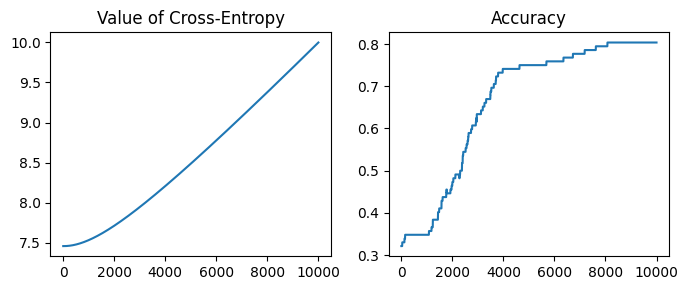

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(7,3))
axs[0].plot(softmaxRegr.entropies)
axs[0].set(title='Value of Cross-Entropy')
axs[1].plot(softmaxRegr.accuracies)
axs[1].set(title='Accuracy')
fig.tight_layout()
fig.show()

After training it seems that, despite increased accuracy, as if the model became a bit biased towards other classes, since the value of the cross-entropy experienced an overall increase. This is an important thing to take into consideration, it is not our case, since all class have similiar representation in the training set:

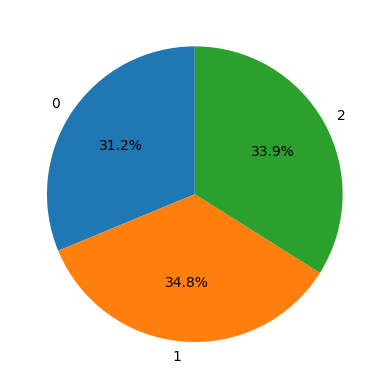

In [25]:
import matplotlib.pyplot as plt

values, counts = np.unique(y_train, return_counts=True)
plt.pie(counts, labels=values, autopct='%1.1f%%', startangle=90)
None

This is a common case for cross-entropy in a multiclass problem. As explained in [this post](https://datascience.stackexchange.com/questions/42599/what-is-the-relationship-between-the-accuracy-and-the-loss-in-deep-learning/42600#42600) or [this Reddit comment](https://www.reddit.com/r/MachineLearning/comments/1895m5k/comment/kbpcfz1/?utm_source=share&utm_medium=web2x&context=3), with more classes the model eventually loses confidence, therefore increasing its entropy. For each invidual cost function it is needed to calculate confidence intervals or apply different tests to measure difference significance.

We can now compare model's inference on the test sample using `scikit-learn` implementation as well as our custom. We can see, that we are lacking accuracy and there's room for improvement using cross-validation:

In [18]:
from sklearn.metrics import classification_report

print(
    classification_report(y_test, softmaxRegr.predict(X_test))
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.36      0.53        11
           2       0.63      1.00      0.77        12

    accuracy                           0.82        38
   macro avg       0.88      0.79      0.77        38
weighted avg       0.88      0.82      0.79        38



In [19]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
yPred = clf.predict(X_test)
print(
    classification_report(y_test, yPred)
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

